# DNN Model

In [200]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [201]:
# data loading from .npz generated from tcr_data_process.ipynb
# loading train data
npz = np.load('data_train.npz')
train_inputs = npz['input'].astype(np.float64)
train_targets = npz['targets'].astype(np.float64)
# loading validation data
npz = np.load('data_validation.npz')
validation_inputs, validation_targets = npz['input'].astype(np.float64), npz['targets'].astype(np.float64)

npz = np.load('data_test.npz')
test_inputs, test_targets = npz['input'].astype(np.float64), npz['targets'].astype(np.float64)

# ANN Model

Outline, Optimizer, Loss function, Early stopping and Training rate

In [202]:
# NN model prep
input_size = 3
output_size = 1
hidden_layer_1_size = 10
hidden_layer_2_size = 10
hidden_layer_3_size = 10

model = tf.keras.Sequential([
    tf.keras.layers.Dense(input_size),
    tf.keras.layers.Dense(hidden_layer_1_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_2_size, activation='relu'),
    #tf.keras.layers.Dense(hidden_layer_3_size, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='linear')
])


In [203]:
# model prep, optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [204]:
# Training
BATCH_SIZE = 1
MAX_EPOCHS = 1000
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

In [205]:
# fit the model
history = model.fit(
    train_inputs, train_targets, batch_size=BATCH_SIZE,epochs=MAX_EPOCHS, callbacks=[early_stopping], validation_data=(validation_inputs, validation_targets), verbose=2
          )

Epoch 1/1000
640/640 - 5s - loss: 1.2195 - root_mean_squared_error: 1.1043 - val_loss: 0.7881 - val_root_mean_squared_error: 0.8878 - 5s/epoch - 7ms/step
Epoch 2/1000
640/640 - 2s - loss: 0.5957 - root_mean_squared_error: 0.7718 - val_loss: 0.3640 - val_root_mean_squared_error: 0.6034 - 2s/epoch - 3ms/step
Epoch 3/1000
640/640 - 1s - loss: 0.2738 - root_mean_squared_error: 0.5233 - val_loss: 0.1712 - val_root_mean_squared_error: 0.4138 - 1s/epoch - 2ms/step
Epoch 4/1000
640/640 - 2s - loss: 0.1236 - root_mean_squared_error: 0.3515 - val_loss: 0.0846 - val_root_mean_squared_error: 0.2908 - 2s/epoch - 3ms/step
Epoch 5/1000
640/640 - 2s - loss: 0.0512 - root_mean_squared_error: 0.2262 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945 - 2s/epoch - 3ms/step
Epoch 6/1000
640/640 - 1s - loss: 0.0214 - root_mean_squared_error: 0.1461 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1327 - 1s/epoch - 2ms/step
Epoch 7/1000
640/640 - 2s - loss: 0.0103 - root_mean_squared_error: 0.1014 -

In [206]:
# ANN model summary
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (1, 3)                    12        
                                                                 
 dense_66 (Dense)            (1, 10)                   40        
                                                                 
 dense_67 (Dense)            (1, 10)                   110       
                                                                 
 dense_68 (Dense)            (1, 1)                    11        
                                                                 
Total params: 173
Trainable params: 173
Non-trainable params: 0
_________________________________________________________________


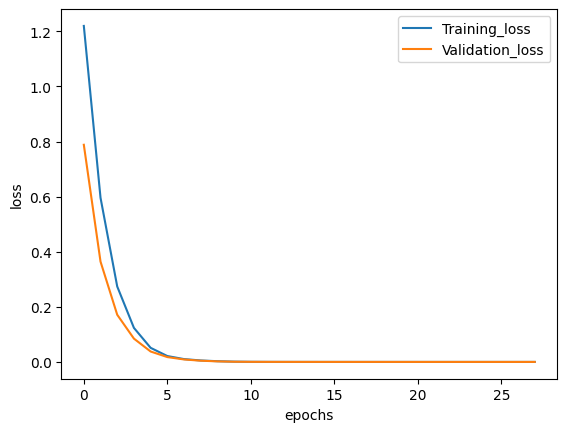

In [207]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training_loss')
plt.plot(history.history['val_loss'], label='Validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Model check on Test data

In [208]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

3/3 [==============================] - 0s 5ms/step - loss: 1.9218e-05 - root_mean_squared_error: 0.0044


In [209]:
print('\nTest loss: {0:.4f}. Test accuracy: {1:.4f} rmse'.format(test_loss, test_accuracy))


Test loss: 0.0000. Test accuracy: 0.0044 rmse


In [223]:
prediction = model.predict(test_inputs)
data_inputs = pd.DataFrame(test_inputs)
prediction = pd.DataFrame(np.round(prediction,3))
test_targets = pd.DataFrame(test_targets)
pred_accu = np.round((prediction/test_targets)*100,2)

result = pd.concat([test_targets, prediction, pred_accu], axis = 1, ignore_index=True)
result.columns = ['Target-St(%)', 'Prediction-St(%)','Pred-Accu-St(%)']
result

3/3 [==============================] - 0s 6ms/step


,Target-St(%),Prediction-St(%),Pred-Accu-St(%)
0,0.99,0.990,100.00
1,0.99,0.990,100.00
2,0.98,0.974,99.39
3,0.99,0.985,99.49
4,1.00,1.000,100.00
...,...,...,...
75,0.94,0.933,99.26
76,0.94,0.933,99.26
77,1.00,1.000,100.00
78,0.97,0.976,100.62


Text(0.5, 0, 'Targets (red) & Predictions (blue)')

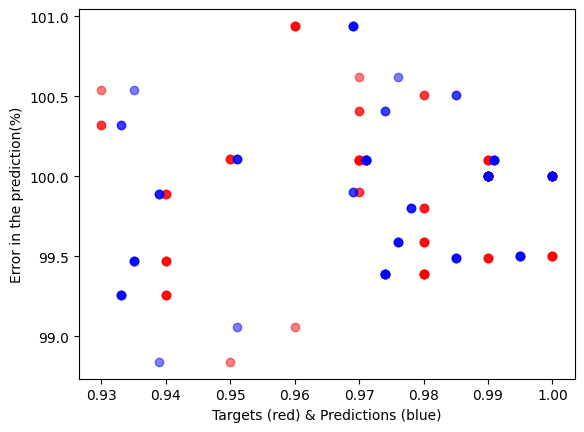

In [224]:
import matplotlib.pyplot as plt
plt.scatter(result['Target-St(%)'], result['Pred-Accu-St(%)'], alpha=0.5, color='r')
plt.scatter(result['Prediction-St(%)'], result['Pred-Accu-St(%)'],alpha=0.5, color='b')
plt.ylabel('Error in the prediction(%)')
plt.xlabel('Targets (red) & Predictions (blue)')

Text(0.5, 0, 'Targets')

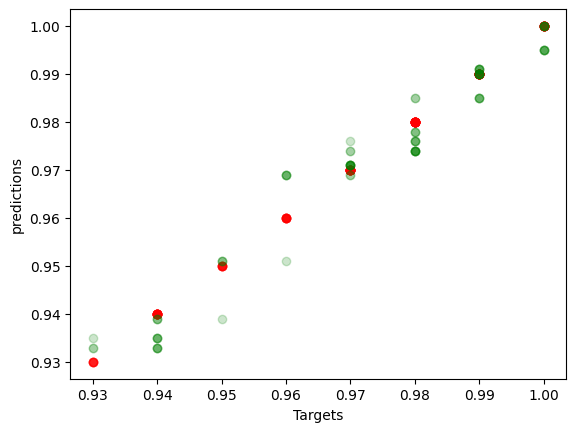

In [225]:
plt.scatter(result['Target-St(%)'], result['Target-St(%)'], alpha=0.5, color='r')
plt.scatter(result['Target-St(%)'], result['Prediction-St(%)'], alpha=0.2, color='g')

plt.ylabel('predictions')
plt.xlabel('Targets')

In [226]:
# estimation of R2 score
from sklearn.metrics import r2_score
r2_score_test = r2_score(test_targets, prediction)
np.round(r2_score_test,4)

0.9546

In [227]:
# estimation of adjusted R2 score
n = np.size(test_targets)
k = 3 # number of features
adj_r2_score = 1 - (((1-r2_score_test)*(n-1))/((n-k-1)))
np.round(adj_r2_score,4)

0.9528

In [228]:
mean_pred = pred_accu.mean()
std_pred = pred_accu.std()
uncertainty_model = std_pred
print("Uncertainty of the ANN model:", np.round(uncertainty_model[0],2), '[%]')
print("Average test prediction precision", np.round(100 - uncertainty_model[0],2), '[%]')

Uncertainty of the ANN model: 0.44 [%]
Average test prediction precision 99.56 [%]


# ANN Model Deployment

ANN model deployment for micro DSC error prediction

In [216]:
import keras
model.save('micro_dsc_dl.h5')